# Lesson 2.1:
# Introduction to the GridAPPS-D APIs

This tutorial provides an overview of the APIs available in GridAPPS-D and how they can be used to perform various tasks, inlcuding pulling power system model data, subscribing to simulation measurements, and publishing equipment control commands.

__Learning Objectives:__

At the end of the tutorial, the user should be able to

* Enumerate the three methods for passing API calls to the GridAPPS-D Platform
* Explain the purpose of the PowerGrid Model API
* Describe the role of the Configuration File API
* List the two common uses of the Simulation API
* Describe some types of data obtained from the Timeseries API

## Getting Started

Before running any of the sample routines in this tutorial, it is first necessary to start the GridAPPS-D Platform and establish a connection to this notebook so that we can start passing calls to the API.

_Open the Ubuntu terminal and start the GridAPPS-D Platform if it is not running already:_

`cd gridappsd-docker`

~/gridappsd-docker$ `./run.sh -t develop`

_Once containers are running,_

gridappsd@[container]:/gridappsd$ `./run-gridappsd.sh`

In [ ]:
# Establish connection to GridAPPS-D Platform:
from gridappsd import GridAPPSD
gapps = GridAPPSD("('localhost', 61613)", username='system', password='manager')

---
# Table of Contents

* [1. GridAPPSD-Python Wrappers](#1.-GridAPPSD-Python-Wrappers)
* [2. PowerGrid Model API](#2.-PowerGrid-Model-API)
* [3. Configuration File API](#3.-Configuration-File-API)
* [4. Simulation API](#4.-Simulation-API)
    * [4.1. Subscribing to Simulation Measurements](#4.1.-Subscribing-to-Simulation-Measurements)
    * [4.2. Publishing Equipment Commands](#4.2.-Publishing-Equipment-Commands)
* [5. Timeseries API](#5.-TimeSeries-API)

---
# 1. GridAPPSD-Python Wrappers

Applications use the set of API call wrappers provided by the GridAPPSD-Python Library to interact with the platform and the various GridAPPS-D APIs. 

A specific GridAPPS-D topic covered in [Lesson 1.4]() is needed to communicate with the GridAPPS-D platform of the correct channel for each API. 

The GridAPPS-D Python provides three core methods for the `gapps = GridAPPSD(...)` object to interact with the platform: 

* `gapps.send(self, topic, message)` -- This method is used to send an API call or publish a command. A response from the API and Platform is NOT expected.


* `gapps.get_response(self, topic, message, timeout=5)` -- This method is used to request information from the API and Platform. A response is expected within the time frame specified by `timeout`.


* `gapps.subscribe(self, topic, callback, id=None)` -- This method is used to subscribe to simulation updates, field measurements, and equipment status changes, as well as general information and log data.



[[Return to Top](#Table-of-Contents)]

---
# 2. PowerGrid Model API

This API allows an app developer to query the PowerGrid Model data store.

In the GridAPPS-D Platform, the power system models (including assets, powerflow data, network topology, and nominal values) reside in the Blazegraph database, which is a graph-based data store. The application queries it using
the GridAPPS-D PowerGrid Model API. 

Using this API, app developers can query for information on the entire feeder model, as well as information for individual pieces of equipment within a feeder model.

Queries are based on the CIM classes presented in [Lesson 1.6]() and use a JSON string or SPARQL query to pull data from the Blazegraph data store. For example, if we want to know the parameters of a particular piece of equipment, such as a switch, we pass an API call like this

In [ ]:
topic = "goss.gridappsd.process.request.data.powergridmodel"
message = """
{
    "modelId": "_4F76A5F9-271D-9EB8-5E31-AA362D86F2C3",
    "requestType": "QUERY_OBJECT_DICT",
    "resultFormat": "JSON",
    "objectType": "LoadBreakSwitch"
}
"""
gapps.get_response(topic, message, timeout=10)

The output of this query in JSON format will have switch information such as (eqid, name, bus1, bus2, phases...) for all the switches that are present in a feeder model identified as modelID in the above message request. 

Similarly, if a user wishes to query for the object measurements, then simply the requestType should be “QUERY_OBJET_MEASUREMENTS” in the above sample
message request. The corresponding response will contain the measurement mrid (“measid”) for each equipment (switch in this case). Note that these measurements mrid are used to check for the operational parameters for equipment.

Usage of the PowerGrid Model API using JSON and SPARQL queries is covered in detail in [Lesson 2.2](Lesson%202.2.%20PowerGrid%20Models%20API%20-%20Using%20JSON%20Queries.ipynb) and [Lesson 2.3](Lesson%202.3.%20PowerGrid%20Model%20API%20-%20Using%20SPARQL%20Queries.ipynb).

[[Return to Top](#Table-of-Contents)]

---
# 3. Configuration File API

The configuration file API generates all configuration files necessary to run a simulation using the GridLAB-D simulator. The user can request the  configuration files or GridLAB-D base files, symbol files, CIM dictionary files. Most of the time, an app developer will not be interested in the configuration files (depends on the nature of the app), and sometimes can use the base GridLAB-D file. The configuration files are stored in a specific directory and contain base GridLAB-D file, start-up file, weather file, player file to drive loads, and other supportive files to run the power flow at a predetermined time step. 

[[Return to Top](#Table-of-Contents)]

---
# 4. Simulation API

The simulation API mainly allows users to start a simulation, subscribe to simulation output and logs messages, and send input to the simulation. 

## 4.1. Subscribing to Simulation Measurements

As discussed in [Lesson 1.4.](), all communications with the GridAPPS-D platform are performed with a particular topic that is unique to each . To subscribe to simulation output, use _simulation.output_ topic and subscribe method are used

* `topic = /topic/goss.gridappsd.simulation.output.[simulation_id]`
* `gapps.subscribe(self, topic, callback, id=None)`

The callback function is invoked when a new simulation output is
generated. The `simulation_id` can be copied from visualization after starting the platform or using the simulation run configuration file.

The response of the above function is the simulation output in form of dictionary which contains all the measurement mrids and their values (can be `magnitude`, `angle`, or `value` depending on the type, including __PNV__ (phase to neutral voltage, magnitude and angle), __VA__ (volt-amperes, magnitude and angle), or __POS__ (position of tap or switch, value) associated with various equipment. 

The application needs to parse these results from the Simulation API using the list of measurement mRIDs, which were obtained previously from the PowerGrid Model API.

The flowchart below illustrates the process of requesting a measurement from the GridAPPS-D and parsing it, as described above.

The application passes a PowerGridModel API call of `"responseType": "QUERY_OBJECT_ MEASUREMENTS"` for a given `"objectType"` will give a list of measurement mRID for a given equipment type. Items in this list are compared against the keys in simulation output to obtain the real-time value. A couple of interesting measurements could be- open switches, capacitor status, nodal voltage, line flow, and so on.

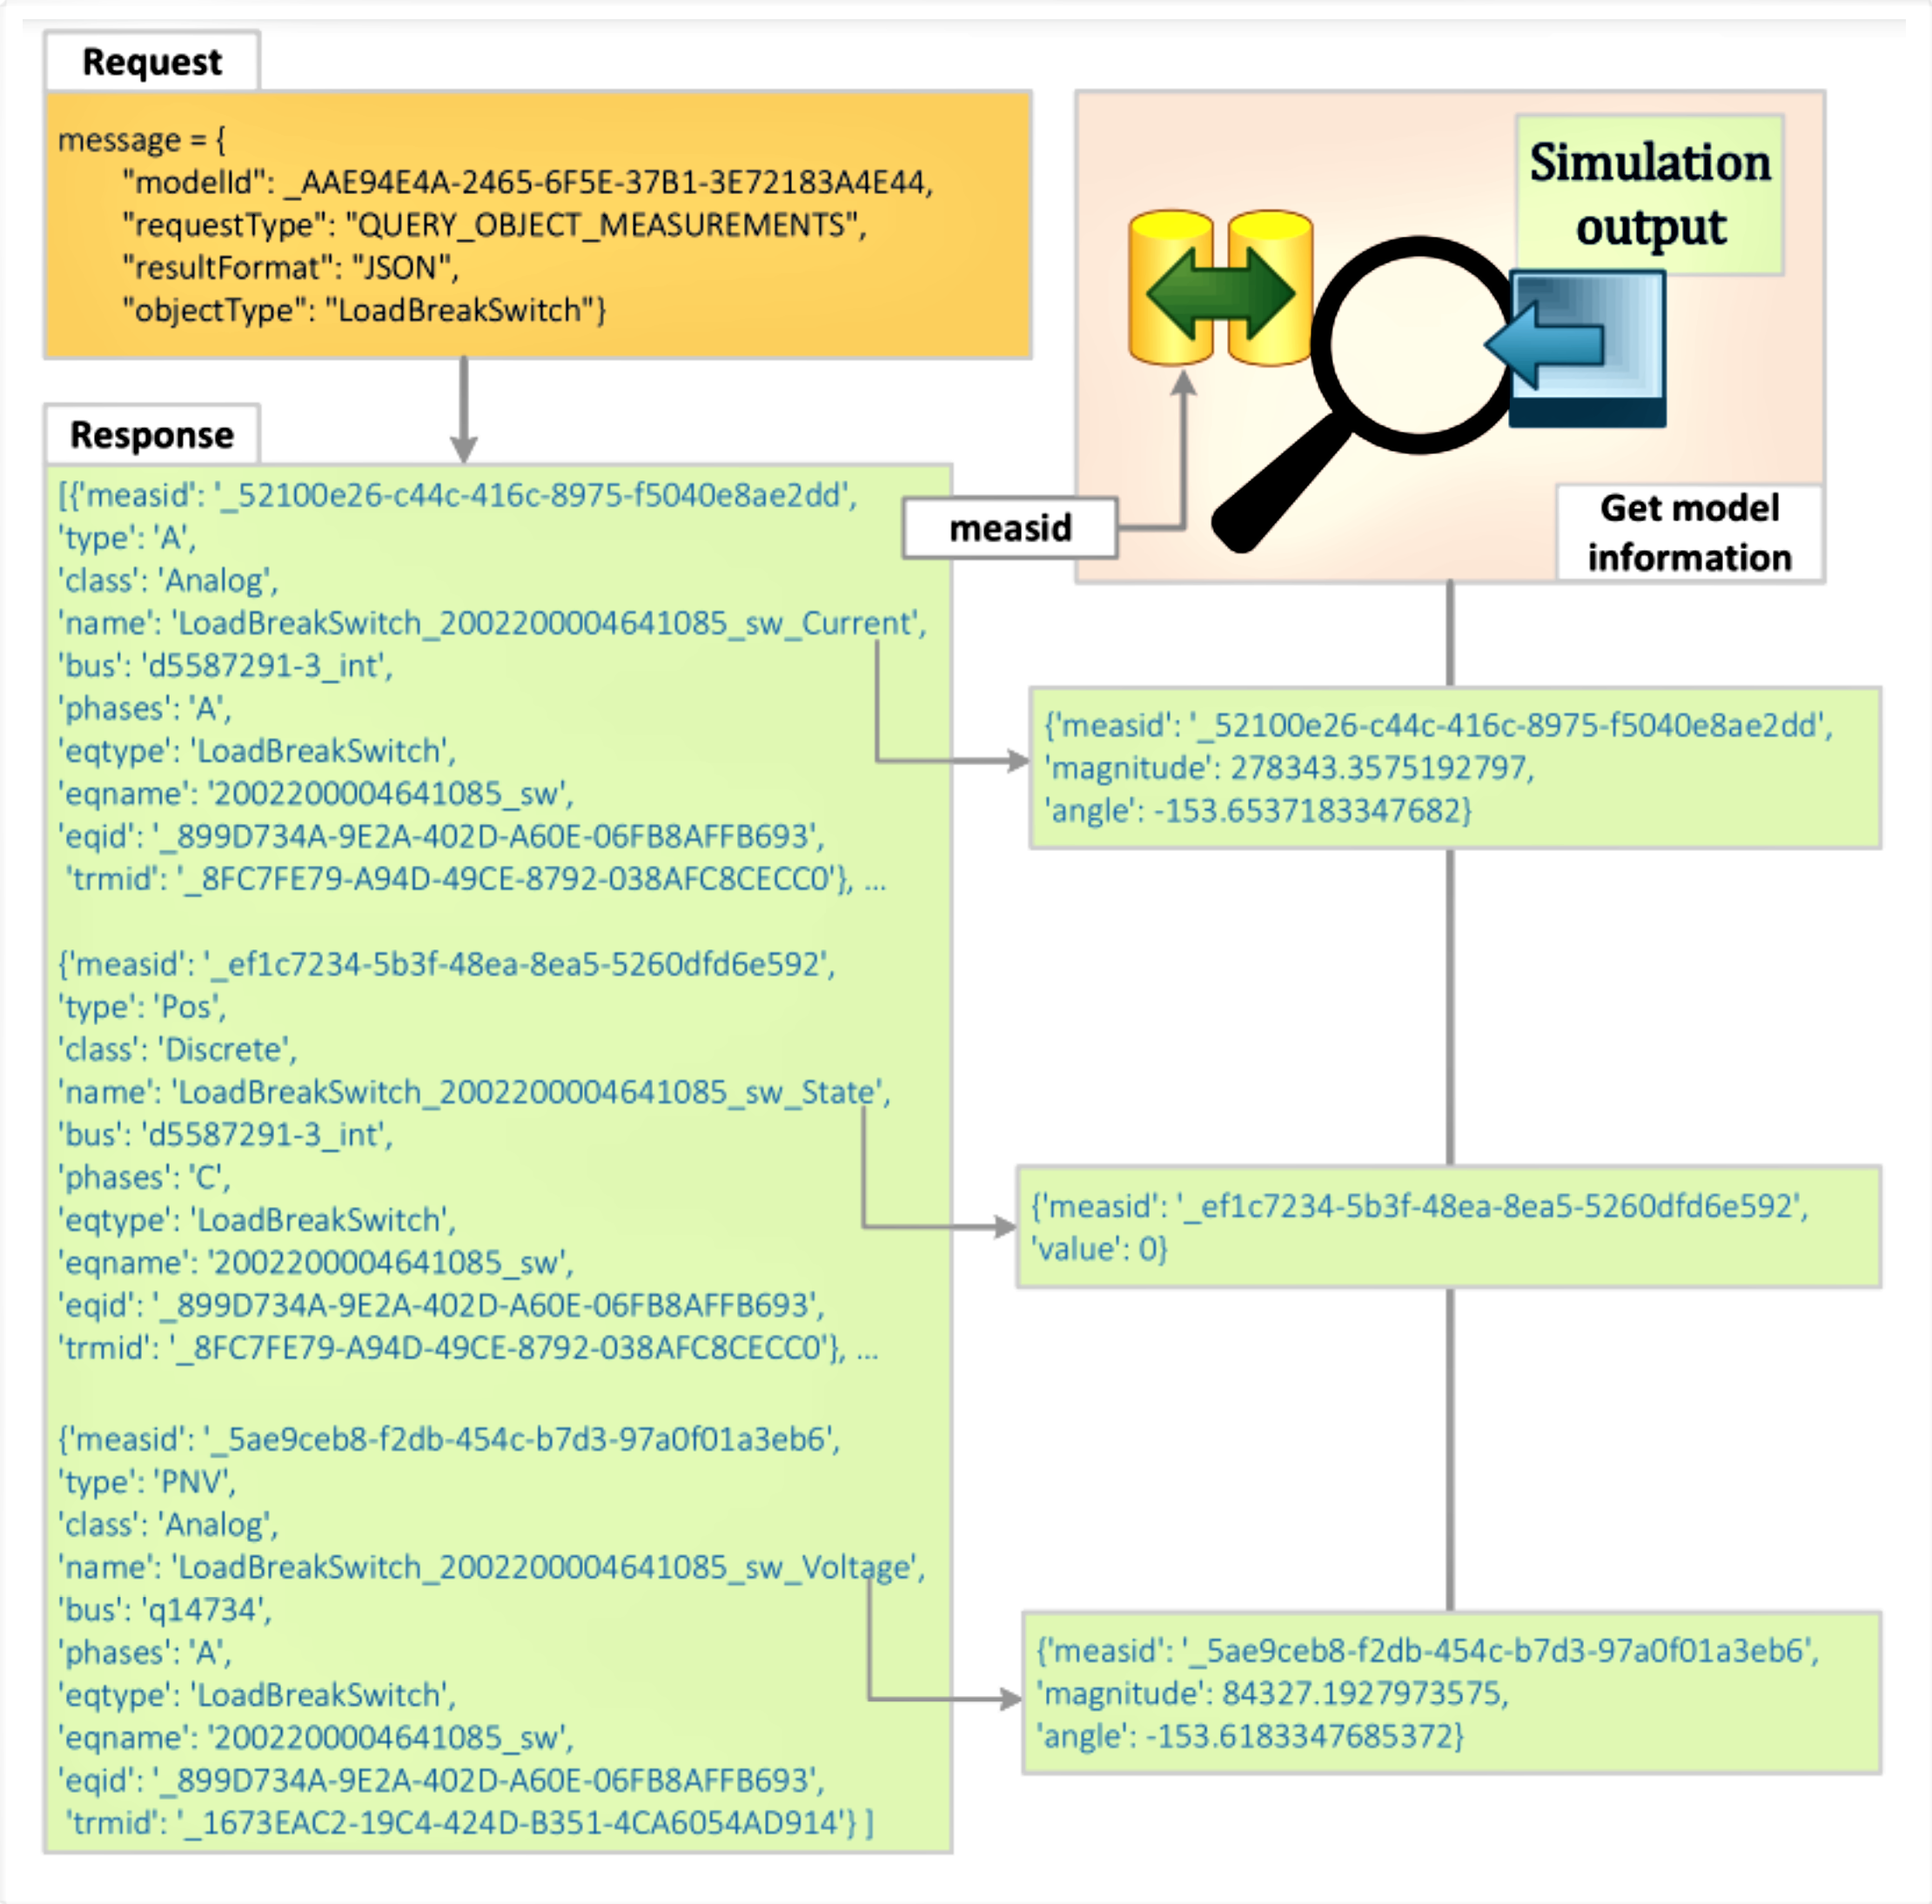

[[Return to Top](#Table-of-Contents)]

## 4.2. Publishing Equipment Commands

Similarly, another important usage of simulation API is to send the simulation input. For example, a reconfiguration application wishes to open a closed switch because of fault, a VVO application wishes to change the tap position of a regulator. We can use simulation API to send the input to simulation using the `send` method for the GridAPPS-D connection object:

* `topic = "/topic/goss.gridappsd.simulation.input.[simulation_id]"`
* `gapps.send(self, topic, message)`

`message` is created using gridappsd-python DifferenceBuilder. The function requires an id of the equipment, attribute for the action, and the value to send. For example, to change a tap position to k for a regulator, the required inputs are mrid for the regulator tap, attribute (TapChanger.step), and a value (such as k = 15). The add_difference and get_message function of a DifferenceBuilder class will create the required JSON message file.


Once this message is sent, the simulator will get updated, and the simulation will change accordingly.

[[Return to Top](#Table-of-Contents)]

---
# 5. TimeSeries API

This API allows the user to query weather, simulation, and sensor service data from the Timeseries Database. Note that while querying the timeseries data, it might feel like drinking from a fire hose. It is always good to have some queryFilter to query only for the required data.

* `topic = "goss.gridappsd.process.request.data.timeseries"
* `gapps.get_response(self, topic, message, timeout=5)`

The message to query weather data, simulation data, and sensor service data respectively is given
below.

_Querying for weather data_

```
message = """
{
    "queryMeasurement":"weather",
    "queryFilter":{"startTime":"000", "endTime":"000",
    "measurement_mrid" = []},
    "responseFormat":"JSON"
}
"""
```
_Querying all simulation data for a given simulation_id_
```
message = """
{
    "queryMeasurement": "simulation",
    "queryFilter": {"simulation_id": "582881157"},
    "responseFormat": "JSON"}

"""
```
_Querying the sensor simulator for a given simulation_id_
```
message = """
{
    "queryMeasurement": " gridappsd-sensor-simulator",
    "queryFilter": {"simulation_id": "582881157",
    “startTime":"000", "endTime":"000"},
    "responseFormat": "JSON"
}

"""
```

[[Return to Top](#Table-of-Contents)]